# Lab 4 - Boosting

## Begin Lab - Import Heart Disease Data

In [2]:
import pandas as pd 


df = pd.read_csv("/Users/jaredmcmullen/Desktop/GSB-S545/data/heart_2020_cleaned.csv")
df['HeartDisease'].describe()

count     319795
unique         2
top           No
freq      292422
Name: HeartDisease, dtype: object

## Balance the dataset - subset half group with heart disease / half without heart disease

In [3]:
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )

balanced = downsample(df, "HeartDisease")
balanced = balanced.dropna()
balanced['HeartDisease'].describe()

count     54746
unique        2
top         Yes
freq      27373
Name: HeartDisease, dtype: object

## Get X/Y variables in format ingestible by models below

In [4]:
import random
from sklearn.preprocessing import LabelEncoder

#Set the seed for analysis
random.seed(10)

#Use label encoder to get in the model ingesting format
for label in balanced.columns:
    balanced[label] = LabelEncoder().fit(balanced[label]).transform(balanced[label])

#Set X and Y values for the models
Y = balanced['HeartDisease']
X = balanced.drop(['HeartDisease'],axis=1)

## Import packages and get the first approach stacking model

In [69]:
#Select all the models you want to test
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

## Set up model evaluation - performs CROSS VALIDATION

In [70]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from numpy import arange

#Create a function to iterate through different models
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state = 1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1) #error_score='raise')
    return scores

## Set up initial models for testing


In [59]:
#Define the models that are going to be iterated through later on 
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['rf'] = RandomForestClassifier()
    models['lr_boost'] = AdaBoostClassifier(base_estimator = LogisticRegression())  
    models['lr_xgboost'] = XGBClassifier(base_estimator = LogisticRegression())
    models['cart_xgboost'] = XGBClassifier(base_estimator = DecisionTreeClassifier())
    models['rf_xgboost'] = XGBClassifier(base_estimator = RandomForestClassifier())
    #models['stacking'] = get_stacking()
    return models

models = get_models()

#Iterate through the models and append the scores
from matplotlib import pyplot
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, Y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
    


>lr 0.735 (0.006)
>rf 0.744 (0.005)
>lr_boost 0.750 (0.004)
>lr_xgboost 0.761 (0.004)
>cart_xgboost 0.761 (0.004)
>rf_xgboost 0.761 (0.004)


## From these results we can see that XGBoosting works the best with this dataset. We will now try and see if stacking the high performing models will yield a different accuracy. 


In [74]:
#Go through the stacking model - we are seperating this so RAM can be utilized when running the notebook
 
    
#Define the stacking model used later on
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr_XGB', XGBClassifier(base_estimator = LogisticRegression())))
    level0.append(('rf_XGB', XGBClassifier(base_estimator = DecisionTreeClassifier())))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model


def get_models():
    models = dict()
    models['stacking'] = get_stacking()
    return models

models = get_models()


#Iterate through the models and append the scores
from matplotlib import pyplot
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, Y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>stacking 0.761 (0.004)


## We can tell from this that stacking isn't necessarily the best option for this dataset - so we will continue tuning the XGB with base models

In [75]:
#Define the models that are going to be iterated through later on 
def get_models():
    models = dict()
    # define number of trees to consider
    learningR = [1, 2, 3, 4]
    for b in learningR:
        models[str(b)] = XGBClassifier(base_estimator = LogisticRegression(),max_depth=b)

        #Explore number of trees
    n_trees = [10, 100, 500, 1000]
    for n in n_trees:
        models[str(n)] = XGBClassifier(base_estimator = LogisticRegression(), n_estimators=n, algorithm='SAMME')

    return models

models = get_models()

#Iterate through the models and append the scores
from matplotlib import pyplot
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, Y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>1 0.763 (0.004)
>2 0.766 (0.004)
>3 0.766 (0.004)
>4 0.765 (0.004)
>10 0.764 (0.005)
>100 0.760 (0.003)
>500 0.748 (0.005)
>1000 0.738 (0.006)


## We will now continue with the learning rate being 3 and continue to iterate

In [81]:
#Define the models that are going to be iterated through later on 
def get_models():
    models = dict()
    learningR = [.03, .05, .1, .3, .5, .7, .9, 1]
    for b in learningR:
        models[str(b)] = XGBClassifier(base_estimator = LogisticRegression(), max_depth = 3, eta = b)  
    return models

models = get_models()

#Iterate through the models and append the scores
from matplotlib import pyplot
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, Y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>0.03 0.762 (0.004)
>0.05 0.764 (0.004)
>0.1 0.766 (0.004)
>0.3 0.766 (0.004)
>0.5 0.764 (0.004)
>0.7 0.762 (0.004)
>0.9 0.760 (0.004)
>1 0.758 (0.005)


## Get the final model 

In [92]:
def get_models():
    models = dict()
    models['lr_XGB'] = XGBClassifier(base_estimator = LogisticRegression(), max_depth = 3, eta = .09)
    return models
models = get_models()

#Iterate through the models and append the scores
from matplotlib import pyplot
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, Y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

>lr_XGB 0.766 (0.004)


## Get the variable importance

[22:09:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "base_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




<BarContainer object of 17 artists>

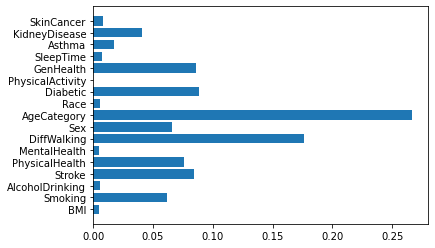

In [102]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error

#Split up the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.20, random_state=0)

model = XGBClassifier(base_estimator = LogisticRegression(), max_depth = 3, eta = .09).fit(X_train,Y_train)

Y_pred = model.predict(X_test)

scores = model.feature_importances_
data_columns = balanced.columns
data_columns = data_columns[1:18]
plt.barh(data_columns, scores)

In conclusion, the best we could make the model was ~ 77% accurate. This was done with a XGBoosted LR model. The most important features were age, diffwalking, and diabetic or not. 